# 9. SAC
SAC (Soft Actor-Critic)算法属于最大熵强化学习。“熵”度量的是随机变量的随机程度，而SAC通过在目标函数中加入一个熵的正则项，使其在最大化累积奖励的同时，还保障了策略的随机性，是一个非常高效的算法。

$$
\pi^* = arg\max_\pi E_{\pi}[\sum_t r(s_t, a_t) + \alpha H(\pi(\cdot|s_t))]
$$

其中，$\alpha$是正则化系数，用于控制熵正则化的强度。alpha 太高，智能体会过于注重熵（过于随机），而忽略了任务的奖励，导致性能不佳。如果 alpha 太低，智能体就会忽视熵（变得过于确定性），失去了SAC算法在探索和鲁棒性上的优势，容易陷入局部最优。

手动去调整 alpha 是非常困难和繁琐的。因此，SAC的作者提出了一个绝妙的解决方案：我们不直接设置 alpha，而是设置一个我们期望策略达到的“熵”的目标值（target_entropy），然后让算法自动学习出一个合适的 alpha 来满足这个目标。
对于连续动作空间，目标熵可以设置为负的动作空间维度。
这个规则的直观理解是，动作空间的维度越高，策略可以“随机”的方向就越多，其潜在的熵也越大。设定一个与维度相关的目标熵，可以为不同复杂度的任务提供一个合理的、尺度一致的起点。

In [1]:
import random
import gymnasium as gym
import numpy as np
from tqdm import tqdm
import torch
import torch.nn.functional as F
from torch.distributions import Normal
import matplotlib.pyplot as plt
import rl_utils

In [ ]:
class PolicyNetContinuous(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound):
        super(PolicyNetContinuous, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc_mu = torch.nn.Linear(hidden_dim, action_dim)    # 均值
        self.fc_std = torch.nn.Linear(hidden_dim, action_dim)   # 标准差
        self.action_bound = action_bound

    def forward(self, x):
        x = F.relu(self.fc1(x))
        mu = self.fc_mu(x)  # 计算均值
        std = F.softplus(self.fc_std(x))   # 使用softplus激活函数 (log(1+exp(x)))，确保标准差永远是正数
        dist = Normal(mu, std)  # 按照均值和标准差创建一个高斯分布的对象
        normal_sample = dist.rsample()  # 从分布中采样 rsample()重参数化采样可以让梯度传回mu和std 更新参数
        log_prob = dist.log_prob(normal_sample) # 计算采样出的对数概率
        action = torch.tanh(normal_sample)  # 压扁到[-1,1] 非线性变换
        # 计算tanh_normal分布的对数概率密度
        log_prob = log_prob - torch.log(1 - torch.tanh(action).pow(2) + 1e-7)
        # 将范围在 [-1, 1] 的动作缩放到环境实际的动作范围
        action = action * self.action_bound
        # 返回动作和修正后的对数动作概率
        return action, log_prob


class QValueNetContinuous(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(QValueNetContinuous, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim + action_dim, hidden_dim)  # 输入状态和动作的拼接向量
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc_out = torch.nn.Linear(hidden_dim, 1)    # 输出动作价值

    def forward(self, x, a):
        cat = torch.cat([x, a], dim=1)
        x = F.relu(self.fc1(cat))
        x = F.relu(self.fc2(x))
        return self.fc_out(x)

tanh_normal分布的对数概率密度推导:

根据概率守恒定律有：
$$
p_Y(y)\cdot |dy| = p_X(x)\cdot |dx|
$$

y和x之间的非线性关系：$y = f(x) = tanh(x)$

两边同时求导：$dy = f'(x)\cdot dx$

代入第一个式子：
$$
p_Y(y) \cdot |f'(x)| \cdot |dx| = p_X(x) \cdot |dx|
$$

$$
p_Y(y) \cdot |f'(x)| = p_X(x)
$$
$$
p_Y(y) = \frac{p_X(x)}{|f'(x)|}
$$

最后两边同时取对数：
$$
log(p_Y(y)) = log(p_X(x)) - log(f'(x)) = log(p_X(x)) - log(1-tanh^2(x))
$$

In [6]:
class SACContinuous:
    ''' 处理连续动作的SAC算法 '''
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound,
                 actor_lr, critic_lr, alpha_lr, target_entropy, tau, gamma,
                 device):
        self.actor = PolicyNetContinuous(state_dim, hidden_dim, action_dim,
                                         action_bound).to(device)  # 策略网络
        # 避免Q值被高估 取这两个Q值中较小的那一个来构建TD Target
        self.critic_1 = QValueNetContinuous(state_dim, hidden_dim,
                                            action_dim).to(device)  # 第一个Q网络
        self.critic_2 = QValueNetContinuous(state_dim, hidden_dim,
                                            action_dim).to(device)  # 第二个Q网络
        # 目标网络 软更新
        self.target_critic_1 = QValueNetContinuous(state_dim,
                                                   hidden_dim, action_dim).to(
                                                       device)  # 第一个目标Q网络
        self.target_critic_2 = QValueNetContinuous(state_dim,
                                                   hidden_dim, action_dim).to(
                                                       device)  # 第二个目标Q网络
        # 令目标Q网络的初始参数和Q网络一样
        self.target_critic_1.load_state_dict(self.critic_1.state_dict())
        self.target_critic_2.load_state_dict(self.critic_2.state_dict())
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),
                                                lr=actor_lr)
        self.critic_1_optimizer = torch.optim.Adam(self.critic_1.parameters(),
                                                   lr=critic_lr)
        self.critic_2_optimizer = torch.optim.Adam(self.critic_2.parameters(),
                                                   lr=critic_lr)
        # 使用alpha的log值,可以使训练结果比较稳定
        self.log_alpha = torch.tensor(np.log(0.01), dtype=torch.float)
        self.log_alpha.requires_grad = True  # 可以对alpha求梯度
        self.log_alpha_optimizer = torch.optim.Adam([self.log_alpha],
                                                    lr=alpha_lr)
        self.target_entropy = target_entropy  # 目标熵的大小
        self.gamma = gamma
        self.tau = tau
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        action = self.actor(state)[0]
        return [action.item()]

    def calc_target(self, rewards, next_states, dones):  # 计算目标Q值
        # 下一个状态及其对数概率
        next_actions, log_prob = self.actor(next_states)
        # 计算熵
        entropy = -log_prob
        # 使用两个目标Critic网络计算下一个状态-动作对的Q值
        q1_value = self.target_critic_1(next_states, next_actions)
        q2_value = self.target_critic_2(next_states, next_actions)
        # Q值=两个目标Q值中较小的一个+熵的正则项
        next_value = torch.min(q1_value,
                               q2_value) + self.log_alpha.exp() * entropy
        # td target
        td_target = rewards + self.gamma * next_value * (1 - dones)
        return td_target

    def soft_update(self, net, target_net):  # 软更新目标网络 同DDPG
        for param_target, param in zip(target_net.parameters(),
                                       net.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - self.tau) +
                                    param.data * self.tau)

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)
        # 和之前章节一样,对倒立摆环境的奖励进行重塑以便训练
        rewards = (rewards + 8.0) / 8.0

        # 更新两个Q网络
        td_target = self.calc_target(rewards, next_states, dones)
        # Critic损失 (均方误差)
        critic_1_loss = torch.mean(
            F.mse_loss(self.critic_1(states, actions), td_target.detach()))
        critic_2_loss = torch.mean(
            F.mse_loss(self.critic_2(states, actions), td_target.detach()))
        # 梯度清零 反向传播 更新参数
        self.critic_1_optimizer.zero_grad()
        critic_1_loss.backward()
        self.critic_1_optimizer.step()
        self.critic_2_optimizer.zero_grad()
        critic_2_loss.backward()
        self.critic_2_optimizer.step()

        # 更新策略网络
        new_actions, log_prob = self.actor(states)
        entropy = -log_prob
        q1_value = self.critic_1(states, new_actions)
        q2_value = self.critic_2(states, new_actions)
        # 目标函数 最小化 (-Q值 - alpha * 熵)
        actor_loss = torch.mean(-self.log_alpha.exp() * entropy -
                                torch.min(q1_value, q2_value))
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # 更新alpha值
        # Alpha的损失函数：目标是使策略的实际熵接近目标熵
        alpha_loss = torch.mean(
            (entropy - self.target_entropy).detach() * self.log_alpha.exp())
        self.log_alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.log_alpha_optimizer.step()

        self.soft_update(self.critic_1, self.target_critic_1)
        self.soft_update(self.critic_2, self.target_critic_2)

In [ ]:
env_name = 'Pendulum-v1'
env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_bound = env.action_space.high[0]  # 动作最大值
random.seed(0)
np.random.seed(0)
env.reset(seed=0)
torch.manual_seed(0)

actor_lr = 3e-4
critic_lr = 3e-3
alpha_lr = 3e-4
num_episodes = 100
hidden_dim = 128
gamma = 0.99
tau = 0.005  # 软更新参数
buffer_size = 100000
minimal_size = 1000
batch_size = 64
target_entropy = -env.action_space.shape[0] # 目标熵可以设置为负的动作空间维度
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

replay_buffer = rl_utils.ReplayBuffer(buffer_size)
agent = SACContinuous(state_dim, hidden_dim, action_dim, action_bound,
                      actor_lr, critic_lr, alpha_lr, target_entropy, tau,
                      gamma, device)

return_list = rl_utils.train_off_policy_agent(env, agent, num_episodes,
                                              replay_buffer, minimal_size,
                                              batch_size)

Iteration 0:   0%|          | 0/10 [00:00<?, ?it/s]/var/folders/_f/bxctsflj2xl2s8d1p9x9bd2r0000gn/T/ipykernel_5106/2202922912.py:38: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/miniconda3/conda-bld/libtorch_1765275721546/work/torch/csrc/utils/tensor_new.cpp:257.)
  state = torch.tensor([state], dtype=torch.float).to(self.device)
Iteration 9: 100%|██████████| 10/10 [00:04<00:00,  2.21it/s, episode=100, return=-188.886]


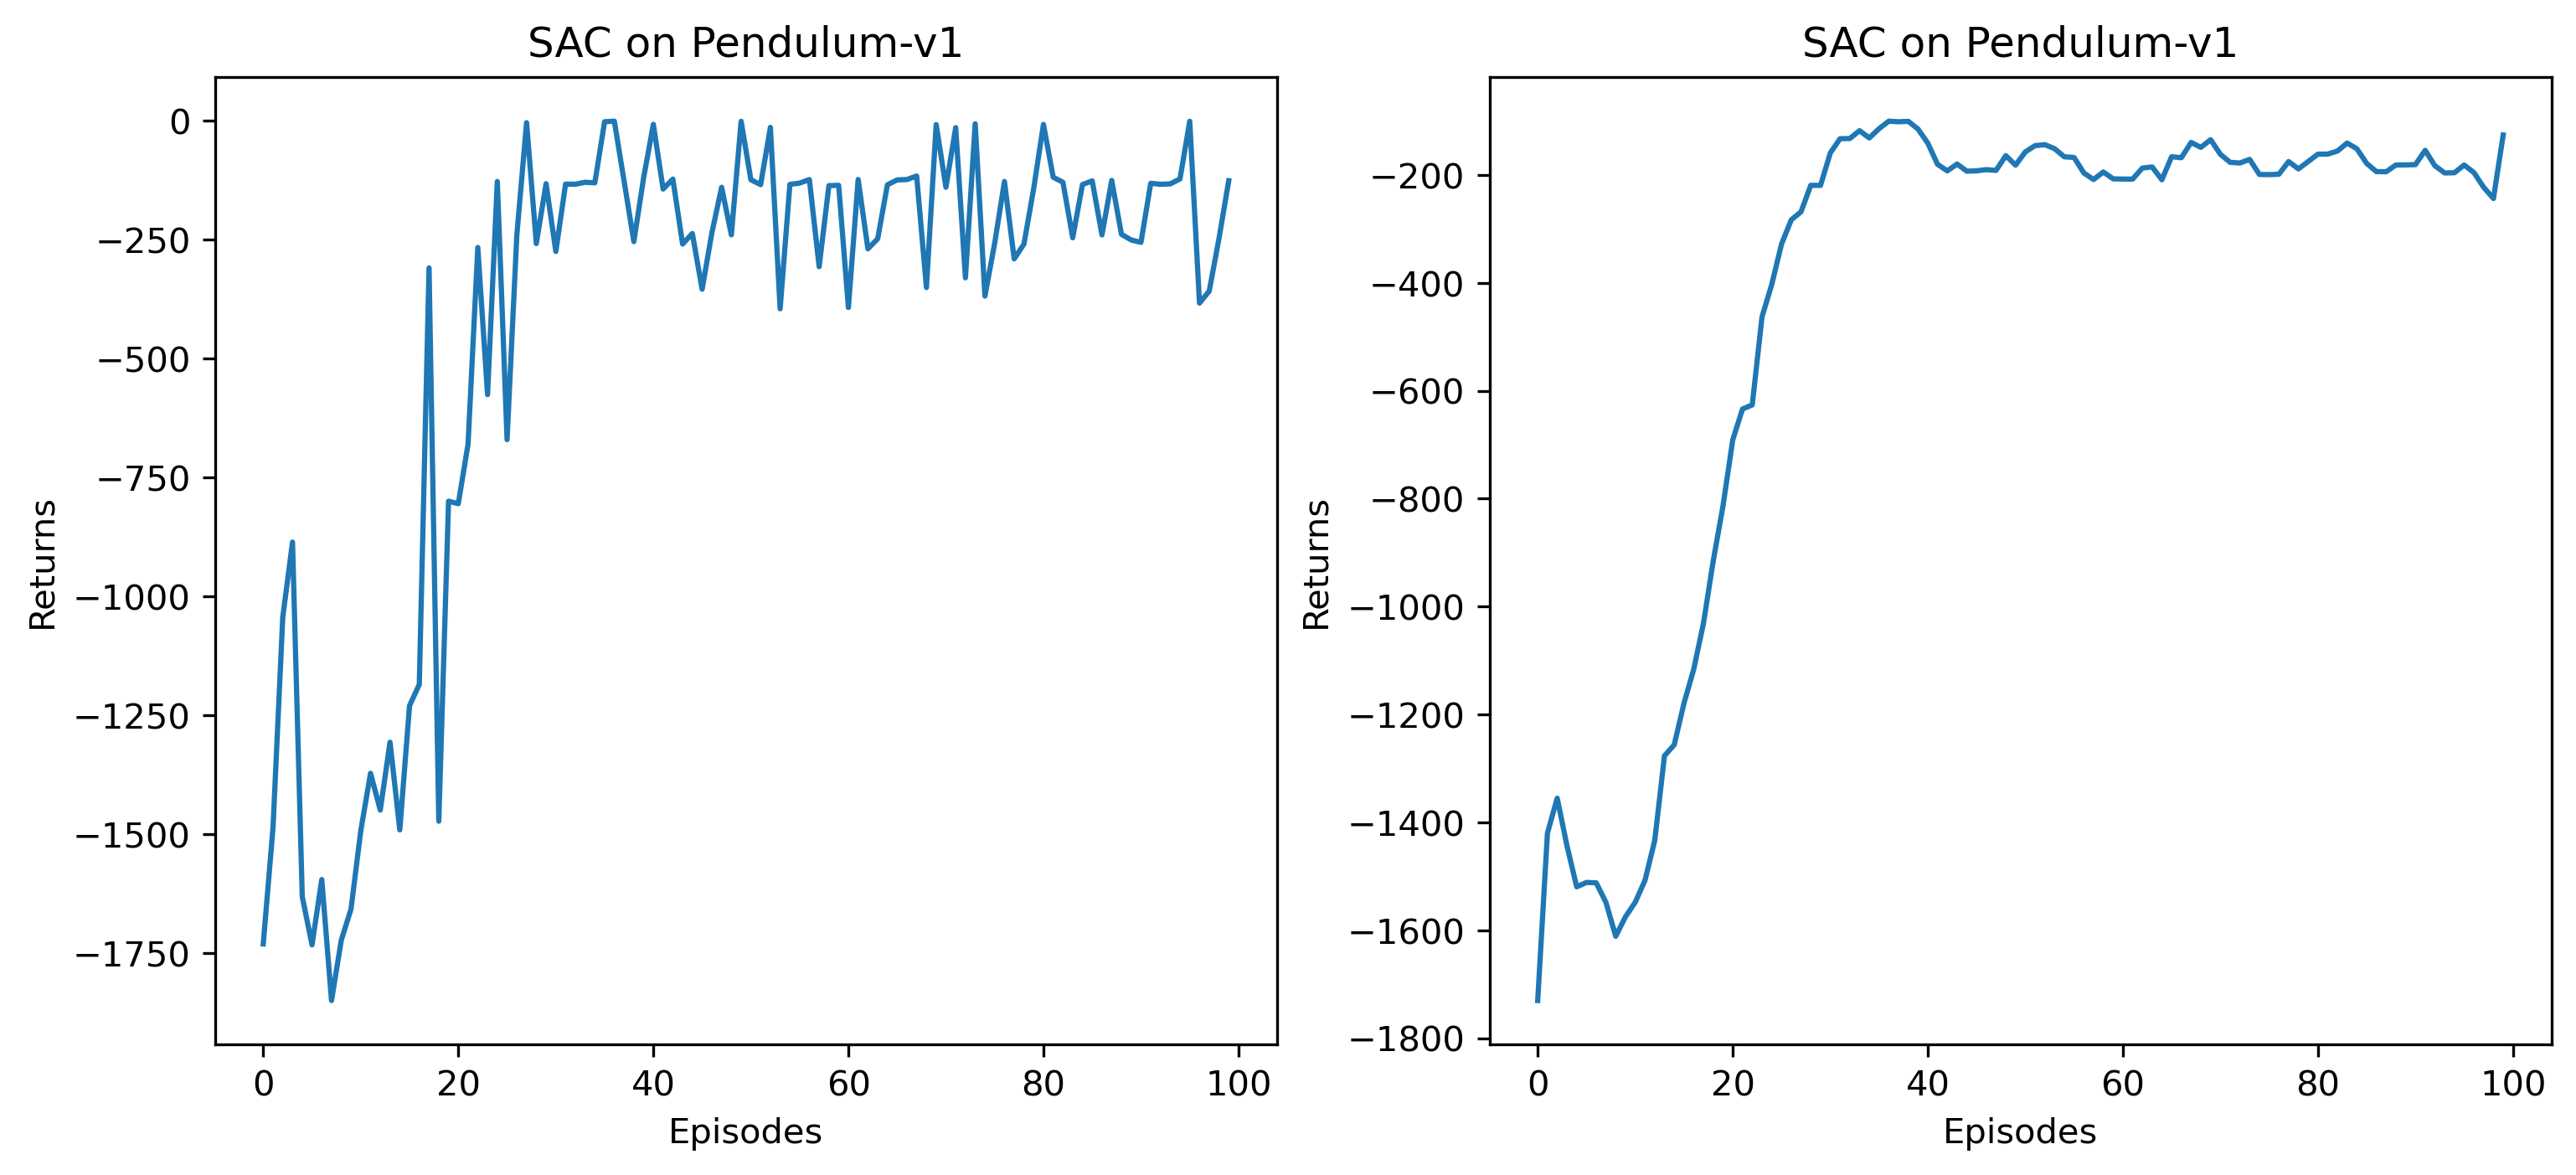

In [5]:
episodes_list = list(range(len(return_list)))
plt.figure(figsize = (12,5), dpi = 300)
plt.subplot(1,2,1)
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('SAC on {}'.format(env_name))
plt.subplot(1,2,2)

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('SAC on {}'.format(env_name))
plt.show()